In [1]:
import os


os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import sys
import os

ROOT_PROJECT_PATH = "/root/AI-Uncomplicated"
# Add the root directory to the sys.path
sys.path.insert(0, ROOT_PROJECT_PATH)

In [3]:
WORKSPACE = os.path.join(ROOT_PROJECT_PATH, "core/models/translator")

In [4]:
from core.models.translator.config import ModelConfig, DatasetConfig, TrainingConfig
from core.dataloaders.dataloader import load_tokenizer

## Initialize configurations
model_config = ModelConfig(model_name="Construe",
                           num_layers = 2,
                            padding_id = 0,
                            hidden_dim = 128,
                            intermediate_dim = 1024,
                            max_positions = 2048,
                            layer_norm_eps = 1e-05,
                            model_max_sequence = 2048,
                            num_heads = 8,
                            attention_dropout = 0.1)

dataset_config = DatasetConfig(dataset_path="./dataset",
                               dataset_shuffle=True)
training_config = TrainingConfig(tokenizer_path="/root/AI-Uncomplicated/core/models/translator/tokenzier/european_tokenizer")

### Translation Dataset

In [5]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dhruvildave/en-fr-translation-dataset")

# print("Path to dataset files:", path)

### Train your tokenizer

In [6]:
# DATASET_DOWNLOAD_PATH = os.path.join(WORKSPACE, "dataset", "cc_100_en_fr")

# if not os.path.exists(DATASET_DOWNLOAD_PATH):
#     os.makedirs(DATASET_DOWNLOAD_PATH)

In [7]:
# TOKENIZER_TRAIN_DATASET_NAME = "statmt/cc100"

In [8]:
# DATA_DOWNLAD_SCRIPT_PATH =  os.path.join(ROOT_PROJECT_PATH, "scripts/hf_data_downloader.py")

# !python $DATA_DOWNLAD_SCRIPT_PATH --dataset $TOKENIZER_TRAIN_DATASET_NAME --working_dir=$DATASET_DOWNLOAD_PATH --allowed_pattern="en/**/*.parquet,fr/**/*.parquet" --revision=convert/parquet

In [9]:
# DATASET_DOWNLOAD_PATH

In [10]:
# DATA_PROCESS_SCRIPT =  os.path.join(ROOT_PROJECT_PATH, "data_processing/parquet/beam_text_writer.py")
# OUTPUT_PATH = os.path.join(DATASET_DOWNLOAD_PATH, "processed_path")
# INPUT_PATH = os.path.join(DATASET_DOWNLOAD_PATH, "statmt/cc100")


# !python $DATA_PROCESS_SCRIPT --input_path=$INPUT_PATH --chunk_size=100000 --output_path=$OUTPUT_PATH --languages=en,fr

In [11]:
# TOKENIZER_TRAINING_SCRIPT = os.path.join(ROOT_PROJECT_PATH, "core/tokenizer/trainer.py")
# MODEL_NAME = "en_fr_combined_tokenizer"
# TOKENIZER_SAVED_PATH = os.path.join(ROOT_PROJECT_PATH, "core/models/translator/tokenzier/")

# !python $TOKENIZER_TRAINING_SCRIPT --data_dir=$OUTPUT_PATH --vocab_size=60000 --model_name=$MODEL_NAME --character_coverage=1.0 --num_threads=100 --output_dir=$TOKENIZER_SAVED_PATH --yaml_file_path="/root/AI-Uncomplicated/core/models/translator/tokenzier/config.yml"

Run below command from project root directory to convert the smp format to custom format we are going to use for training

```bash
python -m core.tokenizer.setencepiece_to_tokenizer --model_path=core/models/translator/tokenzier/en_pt_combined_tokenizer.model --save_path=core/models/translator/tokenzier
```

## Prepare Dataset

### Initialize Model and tokenizer

In [12]:
from core.tokenizer import SPMTokenizer
from core.models.translator.construe import ConstrueAutoRegressiveModel

training_config.tokenizer_path = "/root/AI-Uncomplicated/core/models/translator/tokenzier/en_fr_combined_tokenizer"

tokenizer = SPMTokenizer(training_config.tokenizer_path)

model_config.vocabulary_size = tokenizer.vocab_size
model = ConstrueAutoRegressiveModel(config=model_config)


In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
class EntoPTDataSet(Dataset):
    def __init__(self, tensorflow_dataset):
        self.dataset = tensorflow_dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        return self.dataset[index]


In [15]:
from datasets import Dataset, load_from_disk

try:
    dataset = Dataset.from_csv(os.path.join(path, "en-fr.csv"))
    dataset = dataset.take(3000000)
    dataset = dataset.filter(lambda d: d["en"] is not None and d["fr"] is not None)
    dataset = dataset.filter(lambda x: len(tokenizer.encode(x["en"] + x["fr"], return_type=None)["input_ids"][0]) < 500)
    dataset = dataset.train_test_split(test_size=0.2)
    dataset.save_to_disk("filterd_dataset")
except NameError:
    dataset = load_from_disk("filterd_dataset")

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'fr'],
        num_rows: 2393178
    })
    test: Dataset({
        features: ['en', 'fr'],
        num_rows: 598295
    })
})

In [17]:
train_examples_pt = EntoPTDataSet(dataset["train"])
val_examples_pt = EntoPTDataSet(dataset["test"])

In [18]:
import torch
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from typing import Optional, Callable

def create_data_loader(
    dataset,
    batch_size: int = 32,
    shuffle: bool = True,
    num_workers: int = 4,
    pin_memory: bool = True,
    collate_fn: Optional[Callable] = None,
    drop_last: bool = False,
    generator: Optional[torch.Generator] = None
) -> DataLoader:
    """
    Create a PyTorch DataLoader with optimized settings.
    
    Args:
        dataset: PyTorch Dataset object
        batch_size: Number of samples per batch
        shuffle: Whether to shuffle the data
        num_workers: Number of subprocesses for data loading
        pin_memory: Whether to pin memory in GPU training
        collate_fn: Custom collate function for batching
        drop_last: Whether to drop the last incomplete batch
        generator: Random number generator for reproducibility
    
    Returns:
        DataLoader: Configured PyTorch DataLoader
    """
    

    if collate_fn is None:
        raise ValueError("collator function not provided")

    # Choose sampler based on shuffle parameter
    if shuffle:
        sampler = RandomSampler(dataset, generator=generator)
    else:
        sampler = SequentialSampler(dataset)
    
    # Create DataLoader with optimized settings
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=pin_memory,
        drop_last=drop_last,
        # Worker init function for reproducibility
        worker_init_fn=lambda worker_id: torch.manual_seed(torch.initial_seed() + worker_id)
    )
    
    return loader


class NextTokenPredictionCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
        self.start = tokenizer.model.piece_to_id("<s>")
        self.end = tokenizer.model.piece_to_id("</s>")
        
        self.en_start = tokenizer.model.piece_to_id("<lang_en>")
        self.en_end = tokenizer.model.piece_to_id("</lang_en>")
        self.pt_start = tokenizer.model.piece_to_id("<lang_pt>")
        self.pt_end = tokenizer.model.piece_to_id("</lang_pt>")
        self.pad_token_idx = tokenizer.model.PieceToId("<pad>")
        
    def __call__(self, batch):
        input_ids = []
        labels = []
        
        for item in batch:
            french, english = item["fr"], item["en"]
            
            english_encoded = tokenizer.encode(
                english, return_type=None, add_special_tokens=False
            )["input_ids"][0]
            
            french_encoded = tokenizer.encode(
                french, return_type=None, add_special_tokens=False
            )["input_ids"][0]
            
            
            english_encoded = [self.start] + [self.en_start] +  english_encoded +  [self.en_end]
            french_encoded = [self.pt_start] + french_encoded + [self.pt_end] + [self.end]
            
            input_ids.append(
                english_encoded + french_encoded
            )
            labels.append(
                (english_encoded + french_encoded)[1::] + [self.pad_token_idx]
            )
        
        paddded_tokens = torch.nn.utils.rnn.pad_sequence([torch.tensor(p) for p in input_ids], batch_first=True, padding_value=self.pad_token_idx).long()
        attention_mask = (paddded_tokens != self.pad_token_idx).to(torch.int32)
        
        target = torch.nn.utils.rnn.pad_sequence([torch.tensor(p) for p in labels], batch_first=True, padding_value=self.pad_token_idx).long()
        target = torch.where(attention_mask == 0, -100, target)
        
        return {"input_ids": paddded_tokens, "attention_mask": attention_mask, "labels": target}

In [19]:
collate_fn = NextTokenPredictionCollator(tokenizer=tokenizer)

train_dataloader = create_data_loader(train_examples_pt, collate_fn=collate_fn, batch_size=dataset_config.batch_size)

In [20]:
for batch in train_dataloader:
    break

In [21]:
for l, i in zip(batch["labels"][0].numpy().tolist(), batch["input_ids"][0].numpy().tolist()):
    print(f"{i} -> {l}")

1 -> 6
6 -> 4949
4949 -> 17156
17156 -> 6363
6363 -> 43056
43056 -> 30723
30723 -> 5396
5396 -> 6710
6710 -> 6138
6138 -> 9621
9621 -> 21213
21213 -> 7747
7747 -> 52644
52644 -> 52615
52615 -> 3946
3946 -> 28302
28302 -> 20596
20596 -> 52636
52636 -> 7168
7168 -> 9128
9128 -> 1468
1468 -> 52597
52597 -> 2120
2120 -> 2254
2254 -> 1371
1371 -> 41641
41641 -> 17237
17237 -> 6218
6218 -> 36010
36010 -> 1424
1424 -> 19439
19439 -> 52601
52601 -> 7560
7560 -> 1420
1420 -> 7253
7253 -> 5119
5119 -> 52601
52601 -> 6320
6320 -> 1420
1420 -> 41101
41101 -> 7
7 -> 8
8 -> 7187
7187 -> 30723
30723 -> 52715
52715 -> 4681
4681 -> 17156
17156 -> 6363
6363 -> 14897
14897 -> 1528
1528 -> 52607
52607 -> 19565
19565 -> 52676
52676 -> 21213
21213 -> 7747
7747 -> 7876
7876 -> 4635
4635 -> 1459
1459 -> 3946
3946 -> 20422
20422 -> 3257
3257 -> 30182
30182 -> 52676
52676 -> 9128
9128 -> 1468
1468 -> 52597
52597 -> 2120
2120 -> 2254
2254 -> 1371
1371 -> 17237
17237 -> 52611
52611 -> 19545
19545 -> 16949
16949 -

<Axes: >

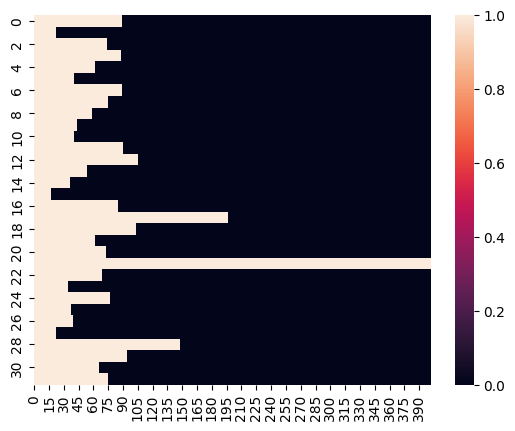

In [22]:
import seaborn as sns

sns.heatmap(batch["attention_mask"].numpy().tolist())

## Training

In [23]:
training_config.warm_up = 4000
training_config.logging_steps = 747

In [24]:
batch = {key: value.to("cpu") for key, value in batch.items()}
pred = model(input_ids=batch["input_ids"], attention_mask = batch["attention_mask"])

In [25]:
import torch.nn.functional as F

def cal_loss(logits, gold, trg_pad_idx, smoothing=False):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''
    n_classes = logits.shape[-1]
    logits = logits.view(-1, n_classes)
    gold = gold.unsqueeze(-1).view(-1)
    loss = F.cross_entropy(logits, gold)
    return loss

In [26]:
pred["logits"].max(-1)[1].shape

torch.Size([32, 402])

In [27]:
model.to("cuda")

ConstrueAutoRegressiveModel(
  (model): ConstrueModel(
    (token_embeddings): Embedding(60000, 128, padding_idx=0)
    (decoder_layers): ModuleList(
      (0-1): 2 x ConstrueDecoderLayer(
        (input_norm): LayerNorm()
        (self_attn): RopeAttention(
          (rope_position_projection): RopePositionEmbedding()
          (qkv_projection): Linear(in_features=128, out_features=384, bias=False)
          (output_projection): Linear(in_features=128, out_features=128, bias=False)
        )
        (attention_dropout): Dropout(p=0.1, inplace=False)
        (post_attention_norm): LayerNorm()
        (mlp): PointWiseGatedProjection(
          (gate_projection): Linear(in_features=128, out_features=1024, bias=False)
          (up_projection): Linear(in_features=128, out_features=1024, bias=False)
          (down_projection): Linear(in_features=1024, out_features=128, bias=False)
          (act_func): PytorchGELUTanh()
        )
        (dropout2): Dropout(p=0.1, inplace=False)
      )
 

In [28]:
def cal_performance(pred, gold, trg_pad_idx=-100):
    ''' Apply label smoothing if needed '''

    loss = cal_loss(pred, gold, trg_pad_idx)

    pred = pred.max(-1)[1].view(-1)
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word

In [29]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import math
from typing import Optional, List

class WarmupCosineScheduler(LambdaLR):
    """Linear warmup and cosine decay scheduler."""
    
    def __init__(
        self,
        optimizer: AdamW,
        warmup_steps: int,
        total_steps: int,
        min_lr_ratio: float = 0.1,
        last_epoch: int = -1
    ):
        """
        Initialize warmup and decay scheduler.
        
        Args:
            optimizer: AdamW optimizer
            warmup_steps: Number of warmup steps
            total_steps: Total number of training steps
            min_lr_ratio: Minimum learning rate ratio compared to initial lr
            last_epoch: The index of the last epoch
        """
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr_ratio = min_lr_ratio
        super().__init__(optimizer, self.lr_lambda, last_epoch)
    
    def lr_lambda(self, current_step: int) -> float:
        """Calculate lr multiplier based on current step."""
        if current_step < self.warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, self.warmup_steps))
        
        # Cosine decay
        progress = float(current_step - self.warmup_steps) / \
            float(max(1, self.total_steps - self.warmup_steps))
        decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        # Scale decay to min_lr_ratio
        decay = self.min_lr_ratio + (1.0 - self.min_lr_ratio) * decay
        return decay

def create_optimizer_and_scheduler(
    model: torch.nn.Module,
    num_training_steps: int,
    learning_rate: float = 5e-5,
    weight_decay: float = 0.01,
    warmup_ratio: float = 0.1,
    min_lr_ratio: float = 0.1,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    no_decay_params: Optional[List[str]] = None
):
    """
    Create AdamW optimizer and warmup scheduler.
    
    Args:
        model: PyTorch model
        num_training_steps: Total number of training steps
        learning_rate: Maximum learning rate after warmup
        weight_decay: Weight decay coefficient
        warmup_ratio: Ratio of warmup steps to total steps
        min_lr_ratio: Minimum learning rate ratio compared to max lr
        beta1: AdamW beta1 parameter
        beta2: AdamW beta2 parameter
        eps: AdamW epsilon parameter
        correct_bias: Whether to correct bias in AdamW
        no_decay_params: List of parameter names that should not have weight decay
    
    Returns:
        tuple: (optimizer, scheduler)
    """
    # Default params that should not have weight decay
    if no_decay_params is None:
        no_decay_params = ['bias', 'LayerNorm.weight', 'layer_norm.weight']
    
    # Separate parameters that should and should not have weight decay
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay_params)
            ],
            "weight_decay": weight_decay,
        },
        {
            "params": [
                p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay_params)
            ],
            "weight_decay": 0.0,
        },
    ]
    
    # Create AdamW optimizer
    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=learning_rate,
        betas=(beta1, beta2),
        eps=eps
    )
    
    # Create scheduler with linear warmup and cosine decay
    print(f"NUM Training Step :: {num_training_steps}")
    
    warmup_steps = int(num_training_steps * warmup_ratio)
    print(f"warmup_steps :: {warmup_steps}")
    
    scheduler = WarmupCosineScheduler(
        optimizer=optimizer,
        warmup_steps=warmup_steps,
        total_steps=num_training_steps,
        min_lr_ratio=min_lr_ratio
    )
    
    return optimizer, scheduler, warmup_steps

In [30]:
from tqdm.notebook import tqdm

def train_step(model, batch, optimizer, scheduler, device, logger=None, gradient_accumulation_steps=1):
    # forward
    labels = batch["labels"].to(device)
    optimizer.zero_grad()
    pred = model(input_ids=batch["input_ids"].to(device), attention_mask=batch["attention_mask"].to(device))
    logits = pred["logits"]
    # backward and update parameters
    loss, n_correct, n_word = cal_performance(logits, labels) 
    loss = loss / gradient_accumulation_steps
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    # if (optimizer.step_count + 1) % gradient_accumulation_steps == 0:
    #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    #     optimizer.step()
    #     scheduler.step()
    #     optimizer.zero_grad()
    
    return loss.item() * gradient_accumulation_steps, n_correct, n_word


In [31]:
from tqdm.notebook import tqdm

def train_epoch(epoch, model, training_data, optimizer, scheduler, device, logging_steps=-1, logger=None, gradient_accumulation_steps=1):
    ''' Epoch operation in training phase'''
    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 

    desc = '  - (Training)   '
    for step, batch in tqdm(enumerate(training_data), mininterval=2, desc=desc, leave=False, total=len(train_dataloader)):
        # forward
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        pred = model(input_ids=batch["input_ids"].to(device), attention_mask=batch["attention_mask"].to(device))
        logits = pred["logits"]
        # backward and update parameters
        loss, n_correct, n_word = cal_performance(logits, labels) 
        
        loss.backward()
        if (optimizer.step_count + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        
        logger.log_metrics(metrics={
            'loss': loss.item(),
            'epoch': epoch,
            "n_correct": n_correct,
            "n_word": n_word,
            'learning_rate': sched.get_current_learning_rate()
        }, step=step)

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [32]:
def calculate_training_steps(
    num_examples: int,
    num_epochs: int,
    batch_size: int,
    gradient_accumulation_steps: int = 1
) -> int:
    """
    Calculate the total number of training steps.
    
    Args:
        num_examples: Total number of training examples
        num_epochs: Number of epochs to train for
        batch_size: Batch size per forward pass
        gradient_accumulation_steps: Number of steps to accumulate gradients
    
    Returns:
        int: Total number of optimizer update steps
    """
    
    update_steps_per_epoch = math.ceil(num_examples / gradient_accumulation_steps)
    
    total_training_steps = update_steps_per_epoch * num_epochs
    
    return total_training_steps

In [33]:
import torch
import logging
import time
from pathlib import Path
import json
from typing import Dict, Any, Optional
from datetime import datetime

class TrainingLogger:
    def __init__(
        self,
        output_dir: str,
        project_name: str,
        log_every_n_steps: int = 100,
        save_every_n_steps: int = 1000,
        save_best_only: bool = True
    ):
        """
        Initialize training logger with various logging options.
        
        Args:
            output_dir: Directory to save checkpoints and logs
            project_name: Name of the project
            use_wandb: Whether to use Weights & Biases logging
            log_every_n_steps: How often to log metrics
            save_every_n_steps: How often to save checkpoints
            save_best_only: Whether to save only the best model
        """
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize logging
        self.log_file = self.output_dir / 'training.log'
        self.setup_logging()
        
        # Training state
        self.global_step = 0
        self.best_loss = float('inf')
        self.start_time = time.time()
        self.last_log_time = self.start_time
        
        # Configuration
        self.log_every_n_steps = log_every_n_steps
        self.save_every_n_steps = save_every_n_steps
            
        # Save configuration
        self.save_config({
            'output_dir': str(output_dir),
            'project_name': project_name,
            'log_every_n_steps': log_every_n_steps,
            'save_every_n_steps': save_every_n_steps,
            'save_best_only': save_best_only,
            'start_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })
    
    def setup_logging(self):
        """Setup logging configuration."""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(self.log_file),
                logging.StreamHandler()
            ]
        )
    
    def save_config(self, config: Dict[str, Any]):
        """Save configuration to JSON file."""
        config_path = self.output_dir / 'config.json'
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
    
    def log_metrics(
        self,
        metrics: Dict[str, float],
        step: Optional[int] = None,
        force_log: bool = False
    ):
        """
        Log metrics to all configured outputs.
        
        Args:
            metrics: Dictionary of metric names and values
            step: Optional step number (uses global_step if not provided)
            force_log: Whether to log regardless of log_every_n_steps
        """
        if step is not None:
            self.global_step = step
        
        # Check if we should log
        if not force_log and self.global_step % self.log_every_n_steps != 0:
            return
        
        # Calculate time statistics
        current_time = time.time()
        elapsed = current_time - self.start_time
        elapsed_since_last = current_time - self.last_log_time
        steps_since_last = self.log_every_n_steps
        steps_per_second = steps_since_last / elapsed_since_last
        
        # Add timing metrics
        metrics.update({
            'elapsed_time': elapsed,
            'steps_per_second': steps_per_second
        })
        
        # Log to terminal and file
        log_str = f'Step {self.global_step}: ' + ', '.join(
            f'{k}: {v}' for k, v in metrics.items()
        )
        logging.info(log_str)
        
        self.last_log_time = current_time
    
    def save_checkpoint(
        self,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        loss: float,
        extra_data: Optional[Dict[str, Any]] = None,
        force_save: bool = False
    ):
        """
        Save model checkpoint.
        
        Args:
            model: PyTorch model
            optimizer: PyTorch optimizer
            loss: Current loss value
            extra_data: Additional data to save in checkpoint
            force_save: Whether to save regardless of save_every_n_steps
        """
        # Check if we should save
        should_save = (
            force_save or
            self.global_step % self.save_every_n_steps == 0 or
            (self.save_best_only and loss < self.best_loss)
        )
        
        if not should_save:
            return
        
        # Update best loss if needed
        if loss < self.best_loss:
            self.best_loss = loss
        
        # Prepare checkpoint data
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': self.global_step,
            'loss': loss,
            'best_loss': self.best_loss
        }
        
        if extra_data:
            checkpoint.update(extra_data)
        
        # Save checkpoint
        checkpoint_path = self.output_dir / f'checkpoint_{self.global_step}.pt'
        torch.save(checkpoint, checkpoint_path)
        
        logging.info(f'Saved checkpoint at step {self.global_step}')
    
    def finish(self):
        """Cleanup and final logging."""
        total_time = time.time() - self.start_time
        logging.info(f'Training finished. Total time: {total_time:.2f}s')

In [34]:
def train(experimentation_name,
          output_dir,
          logging_steps,
          save_steps,
          num_epochs,
          train_dataset,
          collate_fn,
          batch_size,
          gradient_accumulation_steps=1, # not yet implemented
          learning_rate=5e-5,
          warmup_ratio=0.2,
          weight_decay=0.0,
          device="cuda"):
    
    # prepare model
    model.train()
    model.to(device)
    
    train_dataloader = create_data_loader(train_dataset, collate_fn=collate_fn, batch_size=batch_size)
    
    num_training_steps = calculate_training_steps(len(train_dataloader), num_epochs=num_epochs, batch_size=batch_size, gradient_accumulation_steps=gradient_accumulation_steps)

    # Create optimizer and scheduler
    optimizer, scheduler, warmup_steps = create_optimizer_and_scheduler(
        model=model,
        num_training_steps=num_training_steps,
        learning_rate=learning_rate,
        warmup_ratio=warmup_ratio,
        weight_decay=weight_decay
    )
    
    train_logger = TrainingLogger(
        project_name=experimentation_name,
        output_dir=output_dir,
        log_every_n_steps=logging_steps,
        save_every_n_steps=save_steps,
    )

    for epoch in range(num_epochs):
        desc = f'  - (Training)   Epoch {epoch}'
        n_word_total, n_word_correct, total_loss = 0, 0, 0
        for step, batch in tqdm(enumerate(train_dataloader), mininterval=2, desc=desc, leave=False, total=len(train_dataloader)):
            loss, n_correct, n_word = train_step(
                model=model,
                batch=batch,
                optimizer=optimizer,
                scheduler=scheduler,
                device=device,
                gradient_accumulation_steps=gradient_accumulation_steps,
            )
            
            
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss
            
            current_lr = scheduler.get_last_lr()[0]
            
            train_logger.log_metrics(metrics={
                'loss': loss,
                'epoch': epoch,
                "n_correct": n_correct,
                "n_word": n_word,
                'learning_rate': current_lr,
                "warmup_steps": warmup_steps
            }, step=step)
        print()
        print(f"Epoch {epoch} :: loss per word :: {total_loss/n_word_total}")
    train_logger.finish()

In [ ]:
dataset_config.batch_size


collate_fn = NextTokenPredictionCollator(tokenizer=tokenizer)

training_config.logging_steps = 1000
training_config.warm_up = 4000

train(
    experimentation_name=training_config.experimentation_name,
    output_dir=training_config.save_path,
    logging_steps=training_config.logging_steps,
    save_steps=training_config.logging_steps,
    num_epochs= 2, # training_config.num_epochs,
    train_dataset=train_examples_pt,
    collate_fn=collate_fn,
    batch_size=dataset_config.batch_size,
    learning_rate=3e-4,
    warmup_ratio=0.1
)

NUM Training Step :: 149574
warmup_steps :: 14957


  - (Training)   Epoch 0:   0%|          | 0/74787 [00:00<?, ?it/s]

2025-01-19 13:05:47,320 - INFO - Step 0: loss: 11.160490989685059, epoch: 0, n_correct: 0, n_word: 2685, learning_rate: 2.0057498161396e-08, warmup_steps: 14957, elapsed_time: 0.6764383316040039, steps_per_second: 1478.3313618977663


In [ ]:
with open("weights.pt", "wb") as handler:
    torch.save(model.state_dict(), handler)

In [28]:
with open("weights.pt", "rb") as handler:
    state_dict = torch.load(handler)

/tmp/ipykernel_390491/2733062557.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(handler)


In [30]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [487]:
text = "how to enable zia's email intelligence features in zoho crm"

input_ids = tokenizer.encode(text, add_special_tokens=False, return_type=None)["input_ids"]

In [488]:
input_ids = [tokenizer.model.PieceToId("<s>")] + [tokenizer.model.PieceToId("<lang_en>")] +  input_ids[0] + [tokenizer.model.PieceToId("</lang_en>")] + [tokenizer.model.PieceToId("<lang_pt>")]

In [489]:
# model.to("cuda")

In [490]:
input_ids = torch.as_tensor([input_ids])
# input_ids = input_ids.unsqueeze(0)

In [491]:
input_ids

tensor([[    1,     6,  1895,  1409,  9256,  3073,  1966, 52605, 52583,  3980,
         10368,  6032,  1413,  3073,  3248, 52586,  1842, 52593,     7,     8]])

In [653]:
tokenizer.decode(input_ids)

["how to enable zia's email intelligence features in zoho crm Comment faire preuve de l'information sur le savoir-faire de l'information sur les produits de l'information"]

In [654]:
with torch.no_grad():
    outputs = model(input_ids.to("cuda"))

In [655]:
next_token_logits = outputs["logits"][:, -1, :]

In [656]:
next_token_logits

tensor([[-17.3053, -13.8722, -12.7217,  ..., -13.8961, -13.6052, -13.5213]],
       device='cuda:0')

In [657]:
torch.argmax(next_token_logits)

tensor(9, device='cuda:0')

In [658]:
tokenizer.model.id_to_piece(torch.argmax(next_token_logits).item())

'</lang_pt>'

In [659]:
input_ids = torch.hstack([input_ids, torch.as_tensor([[torch.argmax(next_token_logits).item()]])])